In [1]:
import mysql.connector
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [2]:
lab_dict = pd.read_csv('D_LABITEMS.csv', sep = ',')
labevents = pd.read_csv('LABEVENTS.csv', sep = ',')

## Explore the LABEVENTS table
Note that we could do the same thing from MySQL.

In [3]:
labevents.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG
0,281,3,NaN,50820,2101-10-12 16:07:00,7.39,7.39,units,NaN
1,282,3,NaN,50800,2101-10-12 18:17:00,ART,NaN,NaN,NaN
2,283,3,NaN,50802,2101-10-12 18:17:00,-1,-1.00,mEq/L,NaN
3,284,3,NaN,50804,2101-10-12 18:17:00,22,22.00,mEq/L,NaN
4,285,3,NaN,50808,2101-10-12 18:17:00,0.93,0.93,mmol/L,abnormal


We aggregated each lab test by its units, and counted how many lab test record use each unit, and their means and medians

In [4]:
group = labevents.fillna({'VALUEUOM':'?'}).groupby(['ITEMID', 'VALUEUOM'])
lab_sum = group.size().to_frame(name = 'counts')
labevents.set_index('ROW_ID')
lab_sum = (lab_sum
    .join(group.agg({'VALUENUM':'mean'}).rename(columns={'VALUENUM':'mean'}))
    .join(group.agg({'VALUENUM':'median'}).rename(columns={'VALUENUM':'median'}))
    .reset_index()
)

In [5]:
lab_sum.head(n = 10)

,ITEMID,VALUEUOM,counts,mean,median
0,50800,?,404785,NaN,NaN
1,50801,?,5943,457.646524,475.0
2,50801,mm Hg,16073,478.099981,501.0
3,50802,?,20,5.100000,5.0
4,50802,mEq/L,490631,-0.090816,0.0
5,50803,mEq/L,9246,23.847858,24.0
6,50804,?,20,33.500000,35.0
7,50804,MEQ/L,20266,25.918928,26.0
8,50804,mEq/L,470355,26.046331,26.0
9,50805,%,2056,1.757571,1.0


The above table represented lab tests with their local codes (ITEMID column). We can join the lab code dictionary table to get the LOINC coding.

In [6]:
# show the lab dictionary table
lab_dict.head()

,ROW_ID,ITEMID,LABEL,FLUID,CATEGORY,LOINC_CODE
0,546,51346,Blasts,Cerebrospinal Fluid (CSF),Hematology,26447-3
1,547,51347,Eosinophils,Cerebrospinal Fluid (CSF),Hematology,26451-5
2,548,51348,"Hematocrit, CSF",Cerebrospinal Fluid (CSF),Hematology,30398-2
3,549,51349,Hypersegmented Neutrophils,Cerebrospinal Fluid (CSF),Hematology,26506-6
4,550,51350,Immunophenotyping,Cerebrospinal Fluid (CSF),Hematology,NaN


In [7]:
# show the lab summary data with LOINC code
lab_sum.merge(lab_dict, on = 'ITEMID', how = 'outer').head()

,ITEMID,VALUEUOM,counts,mean,median,ROW_ID,LABEL,FLUID,CATEGORY,LOINC_CODE
0,50800,?,404785.0,NaN,NaN,1,SPECIMEN TYPE,BLOOD,BLOOD GAS,NaN
1,50801,?,5943.0,457.646524,475.0,2,Alveolar-arterial Gradient,Blood,Blood Gas,19991-9
2,50801,mm Hg,16073.0,478.099981,501.0,2,Alveolar-arterial Gradient,Blood,Blood Gas,19991-9
3,50802,?,20.0,5.100000,5.0,3,Base Excess,Blood,Blood Gas,11555-0
4,50802,mEq/L,490631.0,-0.090816,0.0,3,Base Excess,Blood,Blood Gas,11555-0


## Explore lab tests after loinc2hpo transformation.
Note the transformed data is not uploaded to the repo or the MySQL database yet...

In [9]:
mimic2hpo = pd.read_csv('lab2hpo.csv', sep = ',')

In [11]:
mimic2hpo.head()

,ROW_ID,NEGATED,MAP_TO
0,281,T,HP:0004360
1,282,U,ERROR 1: local id not mapped to loinc
2,283,T,HP:0032281
3,284,T,HP:0500164
4,285,F,HP:0002901


Note that the last two columns are the LOINC representation of each lab record. 'Negated' indicates whether the HPO term should be negated to represent the medical implication. 

For some lab records, we were not able to transform them into HPO terms. We noted what kind of error caused the failure. Below we calculated success conversion rate and the percentages of each type of failures.

In [14]:
pd.DataFrame({'percentage': 
              mimic2hpo.assign(cat = ['HPO' if x.startswith('HP') else x for x in mimic2hpo.MAP_TO])
              .groupby('cat').size() / len(mimic2hpo) })


,percentage
cat,
ERROR 1: local id not mapped to loinc,0.035987
ERROR 3: loinc code not annotated,0.068701
ERROR 4: interpretation code not mapped to hpo,0.000112
ERROR 5: unable to interpret,0.024710
HPO,0.870490


The result shows we were able to transform 87.0% lab records into HPO terms. The rate is pretty similar to the asthma dataset (88.6%). Note that the annotations were prioritized based on the LOINC frequencies from the asthma dataset. Therefore there might be some bias when comparing loinc2hpo success rate across datasets. But 87% is not far from 88.6%, and some tailed annotations for the ICU patients may bring up the score further. 

The top reason for failing to transform lab tests into HPO is missing annotation ( `ERROR 3` ), which happened for 6.9%  lab tests. For these lab tests, we will be able to map to HPO if we do more annotations. 

The next reason for failing to transform into HPO is that some local lab codes are not mapped to LOINC ( `ERROR 1` : 3.6%). For thse lab tests, we will simply skip them. We do not try to map them into LOINC because the original data provider might have a good reason to not do so.

The third reason for failing to transform into HPO is `ERROR 5: unable to interpret` (2.5%). This error occurs when a lab test result was a nominal type, which we did not consider for now, or was not reported in the expected format, such as using a free text that we were not able to parse. For these lab tests, we may consider to address the nominal types, but that is low priority.

The last reason for not being able to transform into HPO is `ERROR4: interpretation code not mapped to HPO`. This happens when a lab test was interpreted in a code that we do not have annotations for. Because of the low frequency (0.01%), we will omit such lab tests. 

Next, we look at how many HPO terms were assigned to each patient.

In [15]:
mimic2hpo = mimic2hpo.set_index(mimic2hpo.ROW_ID)
labevents = labevents.set_index(labevents.ROW_ID)

In [17]:
combined = labevents.join(mimic2hpo[['NEGATED', 'MAP_TO']], how = 'left')
combined.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG,NEGATED,MAP_TO
ROW_ID,,,,,,,,,,,
281,281,3,NaN,50820,2101-10-12 16:07:00,7.39,7.39,units,NaN,T,HP:0004360
282,282,3,NaN,50800,2101-10-12 18:17:00,ART,NaN,NaN,NaN,U,ERROR 1: local id not mapped to loinc
283,283,3,NaN,50802,2101-10-12 18:17:00,-1,-1.00,mEq/L,NaN,T,HP:0032281
284,284,3,NaN,50804,2101-10-12 18:17:00,22,22.00,mEq/L,NaN,T,HP:0500164
285,285,3,NaN,50808,2101-10-12 18:17:00,0.93,0.93,mmol/L,abnormal,F,HP:0002901


In [19]:
total_hp_count_per_patient = combined[combined.MAP_TO.str.startswith('HP')].groupby('SUBJECT_ID').size().reset_index()
total_hp_count_per_patient.rename(columns = {'SUBJECT_ID': 'patient', 0: 'hpo_n'}, inplace = True)

In [20]:
total_hp_count_per_patient.head()

,patient,hpo_n
0,2,40
1,3,1303
2,4,1433
3,5,17
4,6,1065


In [21]:
# cut the count of hpo into bins
bins = pd.cut(total_hp_count_per_patient.hpo_n, bins = [-1, 0, 100, 500, 1500, 4000, 30000])

In [22]:
total_hp_count_per_patient.groupby(bins).size()

hpo_n
(-1, 0]              0
(0, 100]         10247
(100, 500]       22261
(500, 1500]      10404
(1500, 4000]      2876
(4000, 30000]      463
dtype: int64

We can see that the majority of patients have between 100 - 500 HPO terms. Note that this counts repeated HPO terms multiple times, and counts both normal finds and abnormal findings.

Next, we look at abnormal findings only.

In [23]:
abnormal_hp_count_per_patient = combined[combined.NEGATED == 'F'].groupby('SUBJECT_ID').size().reset_index()


#.groupby(pd.cut('0', bins = [0, 100, 500, 1000, 30000])).size()

In [24]:
abnormal_hp_count_per_patient.groupby(pd.cut(abnormal_hp_count_per_patient.loc[:,0], bins = [0, 100, 500, 1000, 5000, 30000])).size()

0
(0, 100]         24032
(100, 500]       17490
(500, 1000]       2912
(1000, 5000]      1466
(5000, 30000]       17
dtype: int64

Notice that most patients have between 0 - 100 abnormal findings. Note we still count repeated abnormal findings multiple times.

Next, we look at abnormal findings but only look at unique findings for each patient.

In [25]:
patient_group = combined[combined.NEGATED == 'F'].groupby('SUBJECT_ID')

In [27]:
unique_abnormal_hp_count = pd.DataFrame({'patient_id': [group_id for group_id, _ in patient_group],
                                        'abnormal_hpo_n': [len(group.MAP_TO.unique()) for _, group in patient_group]})

In [28]:
unique_abnormal_hp_count = unique_abnormal_hp_count.set_index('patient_id')


In [29]:
unique_abnormal_hp_count.head()

,abnormal_hpo_n
patient_id,
2,14
3,42
4,66
5,5
6,54


In [31]:
unique_abnormal_hp_count.describe()

,abnormal_hpo_n
count,45917.000000
mean,27.806586
std,15.708607
min,1.000000
25%,16.000000
50%,26.000000
75%,38.000000
max,100.000000


The result shows that each patient on average has 27.8 unique abnormal findings in HPO terms. the interquantile range is 16 - 38. 

Next, we are going to infer HPO terms based on HPO hierarchy. Before we do that, we need to define a target and a window, such as 10 days before death?

to continue...

# Explore the MySQL database

In [5]:
mydb = mysql.connector.connect(host='localhost',
                               user='mimicuser',
                               passwd='mimic',
                               database='mimiciiiv13',
                              auth_plugin='mysql_native_password')

In [6]:
cursor = mydb.cursor(buffered=True)

Check that MySQL connection works properly

In [8]:
df = pd.read_sql_query("SELECT * FROM LABEVENTS LIMIT 5;", mydb)
df

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG
0,1,2,163353,51143,2138-07-17 20:48:00,0,0.0,%,None
1,2,2,163353,51144,2138-07-17 20:48:00,0,0.0,%,None
2,3,2,163353,51146,2138-07-17 20:48:00,0,0.0,%,None
3,4,2,163353,51200,2138-07-17 20:48:00,0,0.0,%,None
4,5,2,163353,51221,2138-07-17 20:48:00,0,0.0,%,abnormal


There are some questions we need to further explore. 

* How many times did each patient get admitted into ICU?

From the following query, we can see that about 84% patients were admitted only once, 11% were admitted twice, and the rest 5% were admitted three times or more. We could just focus on the 84%. This will make our task easier as we do not need to worry about effects from other admissions.  

In [9]:
admissions_per_patient = pd.read_sql_query("WITH adm_per_patient AS \
    (SELECT count(*) as adm_time FROM ADMISSIONS GROUP BY SUBJECT_ID) \
    SELECT adm_time, count(*) as patient_n FROM adm_per_patient GROUP BY adm_time ORDER BY patient_n DESC", mydb)
admissions_per_patient['percent'] = admissions_per_patient.patient_n / np.sum(admissions_per_patient.patient_n)
admissions_per_patient[0:10]

,adm_time,patient_n,percent
0,1,38983,0.837984
1,2,5160,0.110920
2,3,1342,0.028848
3,4,508,0.010920
4,5,246,0.005288
5,6,113,0.002429
6,7,51,0.001096
7,8,31,0.000666
8,9,26,0.000559
9,10,14,0.000301


* How many abnormal phenotypes does each patient have at each admission?

From the histogram, we can see that most patients have ~20 abnormal phenotypes. 

In [10]:
cursor.execute("DROP TEMPORARY TABLE IF EXISTS combined")
cursor.execute('''
        CREATE TEMPORARY TABLE IF NOT EXISTS combined AS 
        SELECT LABEVENTS.ROW_ID, LABEVENTS.SUBJECT_ID, LABEVENTS.HADM_ID, LABEVENTS.ITEMID, LABEVENTS.CHARTTIME, 
        LabHpo.NEGATED, LabHpo.MAP_TO 
        FROM LABEVENTS JOIN LabHpo on LABEVENTS.ROW_ID = LabHpo.ROW_ID
   ''')
cursor.execute("CREATE INDEX combined_negated ON combined (NEGATED)")

abnormPerPatientAdm = pd.read_sql_query("WITH abnormal_per_patient_adm AS \
(SELECT SUBJECT_ID, HADM_ID, count(*) AS abnormal_n \
FROM combined WHERE NEGATED = 'F' GROUP BY SUBJECT_ID, HADM_ID) \
SELECT abnormal_n, count(*) AS n FROM abnormal_per_patient_adm GROUP BY abnormal_n ORDER BY n DESC ", mydb)

A better way is to plot this.

In [12]:
abnormalities_per_patient_adm = pd.read_sql_query("SELECT SUBJECT_ID, HADM_ID, count(*) AS abnormal_n \
FROM combined WHERE NEGATED = 'F' GROUP BY SUBJECT_ID, HADM_ID", mydb)
abnormalities_per_patient_adm.abnormal_n.describe()

count    73678.000000
mean       127.217731
std        207.226446
min          1.000000
25%         24.000000
50%         67.000000
75%        142.000000
max       9467.000000
Name: abnormal_n, dtype: float64

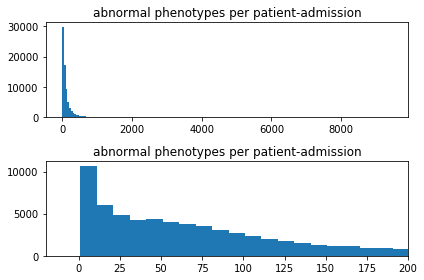

In [13]:
bins = pd.cut(abnormalities_per_patient_adm.abnormal_n, bins = [-1, 0, 25, 50, 75, 100, 125, 150, 175, 200, 3000, 10000])
hist_data = abnormalities_per_patient_adm.groupby(bins).size()
fig = plt.figure()
ax = fig.add_subplot(211)
ax.hist(abnormalities_per_patient_adm.abnormal_n, 
        bins = np.arange(0, np.max(abnormalities_per_patient_adm.abnormal_n), 50))
plt.title('abnormal phenotypes per patient-admission')
ax = fig.add_subplot(212)
ax.hist(abnormalities_per_patient_adm.abnormal_n, 
        bins = np.arange(-9, np.max(abnormalities_per_patient_adm.abnormal_n), 10))
plt.xlim((-20, 200))
plt.title('abnormal phenotypes per patient-admission')
plt.tight_layout()
plt.show()

* How to assign that a patient has a phenotype at one admission?

We look at how many times does each abnormal phenotype occur for each patient admission.

In [14]:
abnormal_occurrence = pd.read_sql_query("SELECT SUBJECT_ID, HADM_ID, MAP_TO, count(*) as n \
    FROM combined \
    WHERE NEGATED = 'F' \
    GROUP BY SUBJECT_ID, HADM_ID, MAP_TO", mydb)
abnormal_occurrence.head()

,SUBJECT_ID,HADM_ID,MAP_TO,n
0,2,163353.0,HP:0031851,1
1,2,163353.0,HP:0020062,1
2,2,163353.0,HP:0025547,2
3,2,163353.0,HP:0025066,1
4,2,163353.0,HP:0001873,1


There is an extreme case where a patient had mapped to 906 Hypercapnia HP:0012416

In [15]:
abnormal_occurrence[abnormal_occurrence.n == 906]

,SUBJECT_ID,HADM_ID,MAP_TO,n
446584,12613,168201.0,HP:0012416,906


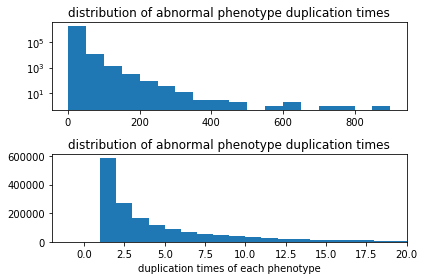

In [16]:
fig = plt.figure()
ax = fig.add_subplot(211)
ax.hist(abnormal_occurrence.n, 
        bins = np.arange(0, np.max(abnormal_occurrence.n), 50))
plt.yscale('log')
plt.title('distribution of abnormal phenotype duplication times')
ax = fig.add_subplot(212)
ax.hist(abnormal_occurrence.n, 
        bins = np.arange(0, np.max(abnormal_occurrence.n), 1))
plt.xlim((-2, 20))
plt.xlabel('duplication times of each phenotype')
plt.title('distribution of abnormal phenotype duplication times')
plt.tight_layout()
plt.show()

From the above plot, we conclude that the majority of HPO only occurred once for every patient at each visit. There are some extreme cases where one patient was assigned with hundreds of HPO terms in one admission. They might indicate patients that had lone stay.

In [17]:
stay_duration = pd.read_sql_query("SELECT \
    SUBJECT_ID, HADM_ID, DISCHTIME, ADMITTIME, CEILING(TIME_TO_SEC(TIMEDIFF(DISCHTIME, ADMITTIME))/(3600 * 24)) as days \
    FROM ADMISSIONS", mydb)
stay_duration.head()

,SUBJECT_ID,HADM_ID,DISCHTIME,ADMITTIME,days
0,2,163353,2138-07-21 15:48:00,2138-07-17 19:04:00,4
1,3,145834,2101-10-31 13:58:00,2101-10-20 19:08:00,11
2,4,185777,2191-03-23 18:41:00,2191-03-16 00:28:00,8
3,5,178980,2103-02-04 12:15:00,2103-02-02 04:31:00,3
4,6,107064,2175-06-15 16:00:00,2175-05-30 07:15:00,17


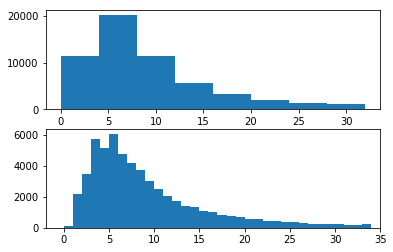

In [18]:
fig = plt.figure()
ax = fig.add_subplot(211)
ax.hist(stay_duration.days, 
        bins = np.arange(0, np.max(stay_duration.days), 4))
ax = fig.add_subplot(212)
ax.hist(stay_duration.days, 
        bins = np.arange(0, np.max(stay_duration.days), 1))
plt.xlim((-2, 35))
plt.show()

Most patients stayed in ICU for around 5 days. 

* What is the common diagnosis at each admission?

In [19]:
diagnosis_count = pd.read_sql_query("SELECT SUBJECT_ID, HADM_ID, \
    CASE \
    WHEN(ICD9_CODE LIKE 'V%') THEN SUBSTRING(ICD9_CODE, 1, 3) \
    WHEN(ICD9_CODE LIKE 'E%') THEN SUBSTRING(ICD9_CODE, 1, 4) \
    ELSE SUBSTRING(ICD9_CODE, 1, 3) END AS ICD9 \
    FROM DIAGNOSES_ICD", mydb)
diagnosis_count.drop_duplicates().groupby('ICD9').size().sort_values(ascending=False).head()

ICD9
401    21305
427    17226
276    15101
272    14558
414    14410
dtype: int64

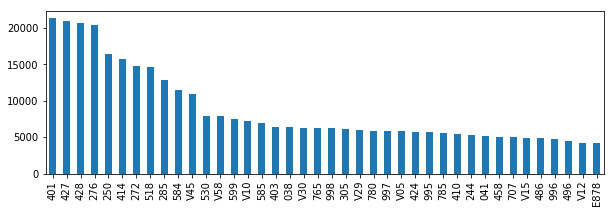

In [21]:
diagnosis_count.ICD9.value_counts().head(n = 40).plot(kind='bar')
fig = plt.gcf()
fig.set_size_inches(10, 3)
plt.show()

The top diagnosis codes are:

* 401 Essential hypertension
* 427 Cardiac dysrhythmias
* 428 Heart failure
* 276 Disorders of fluid, electrolyte, and acid-base balance
* 414 Other forms of chronic ischemic heart disease
* 272 Disorders of lipoid metabolism
* 518 Other diseases of lung
* 285 Other and unspecified anemias
* 584 Acute renal failure
* V45 Other postprocedural states
* 530 Disease of esophagus
* V58 Encounter for other and unspecified procedures and aftercare
* 599 Other disorders of urethra and urinary tract
* V10 Personal history of malignant neoplasm
* 585 Chronic kidney disease (CKD)
* 403 Hypertensive chronic disease
* 038 Septicemia
* V30 Single liveborn
* 765 Disorders relating to short gestation and low birthweight
* 998 Other complications of procedure, NEC
* 305 Nondependent abuse of drugs
* V29 Observation and evaluation of newborns for suspected condition not found
* 780 General symptoms
* 997 Complications affecting specified body systems, not elsewhere classified
* V05 Need for prophylactic vaccination and inoculation against single diseases
* 424 Other diseases of endocardium
* 995 Other anaphylactic react
* 785 Symptoms involving cardiovascular system
* 410 Acute myocardial infarction
* 244 Acquired hypothyroidism
* 041 Bacterial infection in conditions classified elsewhere and of unspecified site
* 458 Hypotension
* 707 Chronic ulcer of skin
* V15 Other personal history presenting hazards to health
* 486 Pneumonia, organism NOS
* 996 Complications peculiar to certain specified procedures
* 496 Chronic airway obstruction
* V12 Personal history of certain other diseases
* E878 Surgical operation and other surgical procedures as the cause of abnormal reaction of patient or of later complication without mention of misadventure at the time of operation